# PyTorch practice, hints, Dataloaders, Conv

Credits:
* First part is based on YSDA [Practical RL course week04 materials](https://github.com/yandexdataschool/Practical_RL/tree/master/week04_%5Brecap%5D_deep_learning).
* Second part is based on PyTorch official tutorials and [this kaggle kernel](https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader)
* Third part is based on PyTorch tutorial by [Stanford CS 231n course](http://cs231n.stanford.edu)

![img](https://pytorch.org/tutorials/_static/pytorch-logo-dark.svg)

__This notebook__ will teach you to use pytorch low-level core. You can install it [here](http://pytorch.org/).

__Pytorch feels__ differently than other frameworks (like tensorflow/theano) on almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

Let's dive into it!

In [ ]:
! pip install pandas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms

### Task 1: Tensormancy

__1.1 The [_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)__

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (6 \cdot \theta) ) \cdot (1 + 0.01 \cdot cos(24 \cdot \theta)) \cdot (0.5 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (10 + sin(10 \cdot \theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

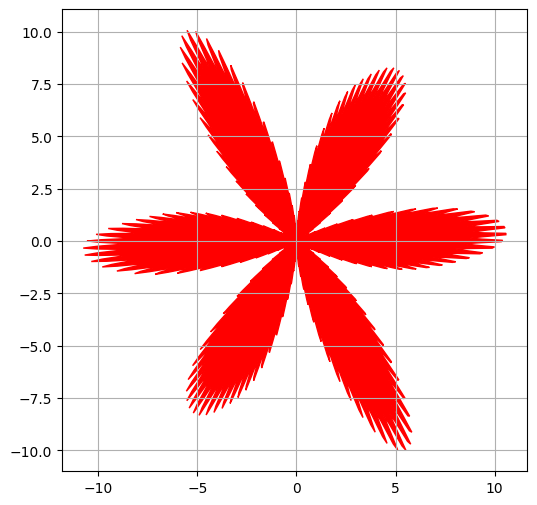

In [ ]:
# creates a one-dimensional tensor
theta = torch.linspace(-np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
# ρ(θ)=(1+0.9·cos(6·θ))·(1+0.01·cos(24·θ))·(0.5+0.05·cos(200·θ))·(10+sin(10·θ))
rho = (1 + 0.9 * torch.cos(6 * theta)) * \
      (1 + 0.01 * torch.cos(24 * theta)) * \
      (0.5 + 0.05 * torch.cos(200 * theta)) * \
      (10 + torch.sin(10 * theta))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)

plt.figure(figsize=(6, 6))
plt.fill(x.numpy(), y.numpy(), color="red")
plt.grid()

### Task 2: Using the Dataloader

In [ ]:
from torch import nn
from torch.nn import functional as F

In [ ]:
!wget https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day10_Optimization_and_regularization_in_DL/notmnist.py

--2025-04-19 10:57:17--  https://raw.githubusercontent.com/neychev/harbour_ml2020/master/day10_Optimization_and_regularization_in_DL/notmnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1799 (1.8K) [text/plain]
Saving to: ‘notmnist.py’

notmnist.py         100%[===================>]   1.76K  --.-KB/s    in 0s      

2025-04-19 10:57:17 (30.9 MB/s) - ‘notmnist.py’ saved [1799/1799]



In [ ]:
!pip install scikit-learn

In [ ]:
from notmnist import load_notmnist

X_train, y_train, X_test, y_test = load_notmnist()

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` that allow you to use pre-loaded datasets as well as your own data. `Dataset` stores the samples and their corresponding labels, and `DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples.

In [ ]:
print(Dataset.__doc__)

An abstract class representing a :class:`Dataset`.

    All datasets that represent a map from keys to data samples should subclass
    it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
    data sample for a given key. Subclasses could also optionally overwrite
    :meth:`__len__`, which is expected to return the size of the dataset by many
    :class:`~torch.utils.data.Sampler` implementations and the default options
    of :class:`~torch.utils.data.DataLoader`. Subclasses could also
    optionally implement :meth:`__getitems__`, for speedup batched samples
    loading. This method accepts list of indices of samples of batch and returns
    list of samples.

    .. note::
      :class:`~torch.utils.data.DataLoader` by default constructs an index
      sampler that yields integral indices.  To make it work with a map-style
      dataset with non-integral indices/keys, a custom sampler must be provided.
    


In [ ]:
import cv2

In [ ]:
class DatasetMNIST(Dataset):
    def __init__(self, path="./notMNIST_small", letters="ABCDEFGHIJ", transform=None):
        self.data, self.labels, _, _ = load_notmnist(path=path, letters=letters, test_size=0)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (C, H, W) --> (H, W, C)
        image = self.data[index].transpose(1, 2, 0)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
full_dataset = DatasetMNIST("./notMNIST_small", "AB", transform=None)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [ ]:
# we can access and get data with index by __getitem__(index)
img, lab = full_dataset.__getitem__(0)

print(img.shape)
print(type(img))

(28, 28, 1)
<class 'numpy.ndarray'>


In [ ]:
full_dataset.__len__()

3745

In [ ]:
a = torchvision.transforms.ToTensor()

print(img.shape)

new_img = a(img)

print(new_img.shape)

(28, 28, 1)
torch.Size([1, 28, 28])


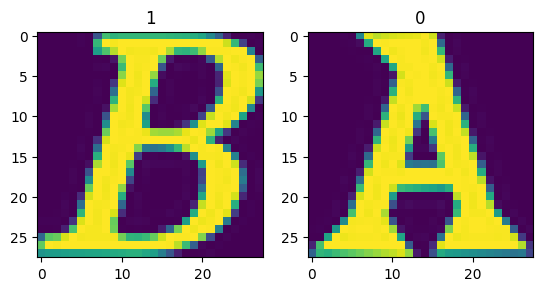

In [ ]:
inds = np.random.randint(len(full_dataset), size=2)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(full_dataset[inds[i]][0].reshape([28, 28]))
    plt.title(str(full_dataset[inds[i]][1]))

#### To the DataLoader

The `Dataset` retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

`DataLoader` is an iterable that abstracts this complexity for us in an easy API.

We have loaded that dataset into the `DataLoader` and can iterate through the dataset as needed. Each iteration below returns a batch of train_features and train_labels (containing `batch_size=8` features and labels respectively). Because we specified `shuffle=True`, after we iterate over all batches the data is shuffled

In [ ]:
train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True, num_workers=1)

We can use dataloader as iterator by using iter() function.

In [ ]:
train_iter = iter(train_loader)
print(type(train_iter))

<class 'torch.utils.data.dataloader._MultiProcessingDataLoaderIter'>


We can look at images and labels of batch size by extracting data `.next()` method.

In [ ]:
images, labels = next(train_iter)
# images, labels = train_iter.__next__()

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

images shape on batch size = torch.Size([8, 28, 28, 1])
labels shape on batch size = torch.Size([8])


Text(0.5, 1.0, '[1 1 1 1 0 1 0 1]')

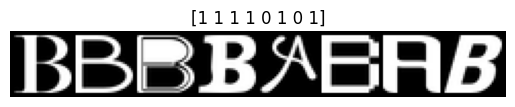

In [ ]:
# tensor : (batchsize, channels, height, width)
# Assuming images are in (B, H, W, C) format (e.g., from PIL/numpy loading)
if images.dim() == 4 and images.size(1) != 3:  # If channels aren't in position 1
    images = images.permute(0, 3, 1, 2)  # (B, H, W, C) -> (B, C, H, W)

# Normalize images to [0,1] range if they aren't already
# https://en.wikipedia.org/wiki/Feature_scaling
if images.min() < 0 or images.max() > 1:
    images = (images - images.min()) / (images.max() - images.min())

# Create grid (now expects (B, C, H, W))
grid = torchvision.utils.make_grid(images)

# Convert to numpy and change to (H, W, C) for matplotlib
grid_np = grid.numpy().transpose(1, 2, 0)

plt.imshow(grid_np)
plt.axis("off")
plt.title(labels.numpy())

And now with transformations:

In [ ]:
train_dataset_with_transform = DatasetMNIST(transform=torchvision.transforms.ToTensor())

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


In [ ]:
img, lab = train_dataset_with_transform.__getitem__(0)

print("image shape at the first row : {}".format(img.size()))

image shape at the first row : torch.Size([1, 28, 28])


In [ ]:
train_loader_tr = DataLoader(train_dataset_with_transform, batch_size=8, shuffle=True)

train_iter_tr = iter(train_loader_tr)
print(type(train_iter_tr))

images, labels = next(train_iter_tr)

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([8, 1, 28, 28])
labels shape on batch size = torch.Size([8])


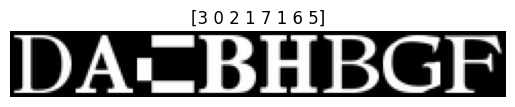

In [ ]:
if images.min() < 0 or images.max() > 1:
    images = (images - images.min()) / (images.max() - images.min())

grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis("off")
plt.title(labels.numpy());

### Composing several transformations

If you want to take data augmentation, you have to make List using `torchvision.transforms.Compose`

```
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        format_string = self.__class__.__name__ + '('
        for t in self.transforms:
            format_string += '\n'
            format_string += '    {0}'.format(t)
        format_string += '\n)'
        return format_string
```


this function can convert some image by order within `__call__` method.

In [ ]:
class Flatten:
    def __call__(self, pic):
        return pic.flatten()

    def __repr__(self):
        return self.__class__.__name__ + "()"

In [ ]:
a = Flatten()

In [ ]:
print(a)

Flatten()


In [ ]:
print(a(img).shape)

torch.Size([784])


In [ ]:
a(img).shape.__repr__()

'torch.Size([784])'

In [ ]:
flatten_transform = Flatten()

# Применяем к изображению
flattened_img = flatten_transform(img)

print(flattened_img.shape)  # Вывод: torch.Size([3072])  (3 * 32 * 32 = 3072)

torch.Size([784])


In [ ]:
new_transform = torchvision.transforms.Compose([
#     torchvision.transforms.CenterCrop(),
#     torchvision.transforms.Resize((640, 460)),
    torchvision.transforms.ToTensor(),
    Flatten(),
])

# Putting all together

In [ ]:
import time

from IPython.display import clear_output

In [ ]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [ ]:
def subset_ind(dataset, ratio: float):
    #     return ### YOUR CODE HERE
    return np.random.choice(len(dataset), size=int(ratio * len(dataset)), replace=False)

In [ ]:
dataset = DatasetMNIST(
    "./notMNIST_small",
    # 'AB',
    transform=new_transform,
)

shrink_inds = subset_ind(dataset, 0.2)
dataset = Subset(dataset, shrink_inds)

print(f"\n\n dataset size: {len(dataset)}, labels: {np.unique(dataset.dataset.labels)}")

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
Done


 dataset size: 3744, labels: [0 1 2 3 4 5 6 7 8 9]


In [ ]:
val_size = 0.2
val_inds = subset_ind(dataset, val_size)

train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

print(f"  training size: {len(train_dataset)}\nvalidation size: {len(val_dataset)}")

  training size: 2996
validation size: 748


In [ ]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = train_iter.__next__()

print("images shape on batch size = {}".format(images.size()))
print("labels shape on batch size = {}".format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([32, 784])
labels shape on batch size = torch.Size([32])


In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
default_dtype = torch.float32

In [ ]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 10),
    nn.Sigmoid(),
)
model.to(device, default_dtype)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
preds = torch.rand(3, 10)
preds

tensor([[6.7738e-01, 5.1575e-01, 3.9657e-01, 6.0886e-02, 6.0673e-01, 4.0811e-02,
         7.9526e-01, 4.8593e-02, 2.8921e-01, 7.8395e-01],
        [4.5555e-01, 9.2365e-01, 2.8440e-01, 7.5016e-01, 3.6330e-01, 4.8565e-01,
         9.6399e-01, 3.6730e-01, 5.6164e-01, 2.1738e-04],
        [8.9130e-01, 6.6436e-01, 9.8279e-01, 1.7283e-01, 5.8046e-01, 5.5523e-01,
         9.4228e-01, 3.0132e-01, 6.8729e-01, 7.0562e-02]])

In [ ]:
vals, inds = preds.max(axis=-1)

In [ ]:
inds

tensor([6, 6, 2])

In [ ]:
vals

tensor([0.7953, 0.9640, 0.9828])

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    """
    model: nn tp train
    train_loader, val_loader: data loaders
    loss_fn: loss function to minimize
    opt: optimizer to update NN weights using gradient descent
    n_epochs: number of epochs = number of full data iterations
    """
    train_loss = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        start_time = time.time()

        model.train(True)  # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)

            opt.zero_grad()
            loss.backward()

            opt.step()

            ep_train_loss.append(loss.item())

        model.train(False)  # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                # YOUR CODE HERE
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                preds = model(X_batch)
                loss = loss_fn(preds, y_batch)

                # compute predictions
                # YOUR CODE HERE
                ep_val_loss.append(loss.item())  # YOUR CODE HERE
                y_pred = preds.max(-1)[1]  # YOUR CODE HERE
                ep_val_accuracy.append((y_pred == y_batch).to(default_dtype).mean().item())  # YOUR CODE HERE

        # print the results for this epoch:
        print(f"Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s")

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy

In [ ]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 0.239s
	  training loss: 1.849743
	validation loss: 1.733032
	validation accuracy: 0.838
Epoch 2 of 30 took 0.192s
	  training loss: 1.702016
	validation loss: 1.682845
	validation accuracy: 0.867
Epoch 3 of 30 took 0.206s
	  training loss: 1.667022
	validation loss: 1.661807
	validation accuracy: 0.879
Epoch 4 of 30 took 0.171s
	  training loss: 1.647272
	validation loss: 1.655454
	validation accuracy: 0.876
Epoch 5 of 30 took 0.259s
	  training loss: 1.634561
	validation loss: 1.648522
	validation accuracy: 0.873
Epoch 6 of 30 took 0.265s
	  training loss: 1.624159
	validation loss: 1.639102
	validation accuracy: 0.876
Epoch 7 of 30 took 0.266s
	  training loss: 1.616192
	validation loss: 1.638810
	validation accuracy: 0.873
Epoch 8 of 30 took 0.280s
	  training loss: 1.610060
	validation loss: 1.636697
	validation accuracy: 0.868
Epoch 9 of 30 took 0.269s
	  training loss: 1.605035
	validation loss: 1.627985
	validation accuracy: 0.875
Epoch 10 of 30 took 0.246s
	

In [ ]:
def plot_train_process(train_loss, val_loss, val_accuracy):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title("Loss")
    axes[0].plot(train_loss, label="train")
    axes[0].plot(val_loss, label="validation")
    axes[0].legend()

    axes[1].set_title("Validation accuracy")
    axes[1].plot(val_accuracy)

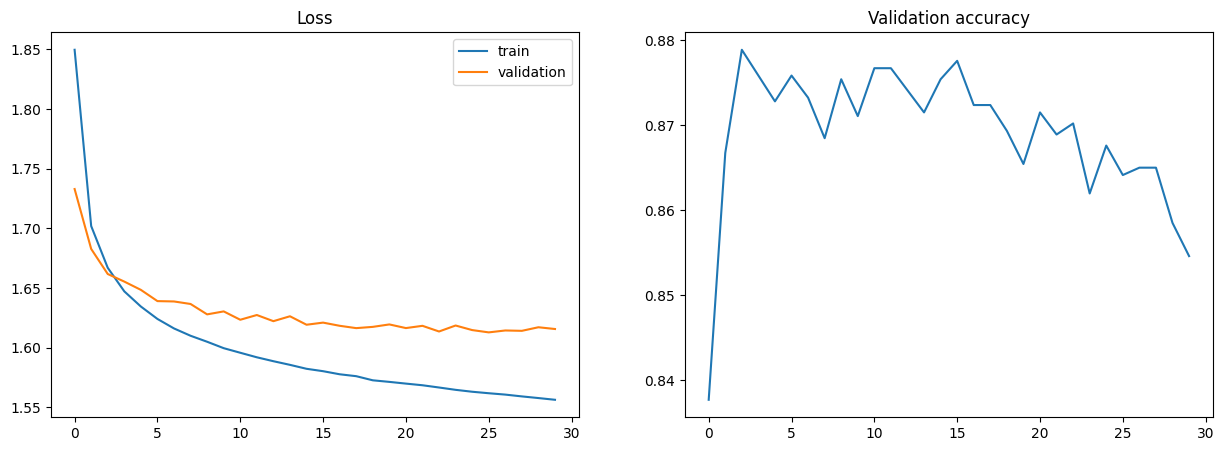

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Real network

In [ ]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.ReLU(),
    nn.Linear(500, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 0.819s
	  training loss: 1.714824
	validation loss: 1.596801
	validation accuracy: 0.842
Epoch 2 of 30 took 0.713s
	  training loss: 1.585911
	validation loss: 1.566696
	validation accuracy: 0.888
Epoch 3 of 30 took 0.737s
	  training loss: 1.554072
	validation loss: 1.576055
	validation accuracy: 0.874
Epoch 4 of 30 took 0.727s
	  training loss: 1.539069
	validation loss: 1.559001
	validation accuracy: 0.892
Epoch 5 of 30 took 0.750s
	  training loss: 1.529614
	validation loss: 1.554413
	validation accuracy: 0.896
Epoch 6 of 30 took 0.730s
	  training loss: 1.523497
	validation loss: 1.553922
	validation accuracy: 0.900
Epoch 7 of 30 took 0.759s
	  training loss: 1.515465
	validation loss: 1.560122
	validation accuracy: 0.893
Epoch 8 of 30 took 0.857s
	  training loss: 1.511101
	validation loss: 1.557756
	validation accuracy: 0.901
Epoch 9 of 30 took 0.882s
	  training loss: 1.510621
	validation loss: 1.567423
	validation accuracy: 0.888
Epoch 10 of 30 took 0.903s
	

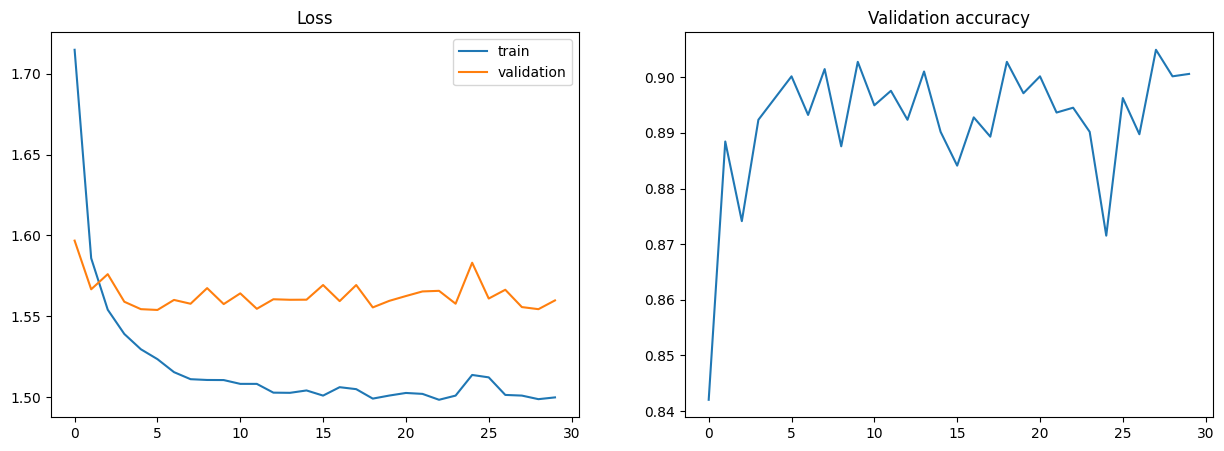

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

In [ ]:
import torchsummary

In [ ]:
torchsummary.summary(model, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 500]         392,500
              ReLU-2                  [-1, 500]               0
            Linear-3                  [-1, 200]         100,200
              ReLU-4                  [-1, 200]               0
            Linear-5                   [-1, 10]           2,010
           Sigmoid-6                   [-1, 10]               0
Total params: 494,710
Trainable params: 494,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.89
Estimated Total Size (MB): 1.90
----------------------------------------------------------------


## Overfit!!!

In [ ]:
# create network again just in case
model = nn.Sequential(
    nn.Linear(784, 600),
    nn.ReLU(),
    nn.Linear(600, 500),
    nn.ReLU(),
    nn.Linear(500, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 10),
    nn.Sigmoid(),
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 1.489s
	  training loss: 1.745472
	validation loss: 1.625398
	validation accuracy: 0.742
Epoch 2 of 30 took 1.439s
	  training loss: 1.628245
	validation loss: 1.635847
	validation accuracy: 0.733
Epoch 3 of 30 took 1.409s
	  training loss: 1.615345
	validation loss: 1.599577
	validation accuracy: 0.783
Epoch 4 of 30 took 1.679s
	  training loss: 1.601765
	validation loss: 1.632425
	validation accuracy: 0.730
Epoch 5 of 30 took 2.026s
	  training loss: 1.613775
	validation loss: 1.610055
	validation accuracy: 0.691
Epoch 6 of 30 took 1.481s
	  training loss: 1.617867
	validation loss: 1.626890
	validation accuracy: 0.682
Epoch 7 of 30 took 1.880s
	  training loss: 1.606956
	validation loss: 1.609161
	validation accuracy: 0.734
Epoch 8 of 30 took 2.205s
	  training loss: 1.619546
	validation loss: 1.619149
	validation accuracy: 0.766
Epoch 9 of 30 took 2.759s
	  training loss: 1.618383
	validation loss: 1.644446
	validation accuracy: 0.671
Epoch 10 of 30 took 2.930s
	

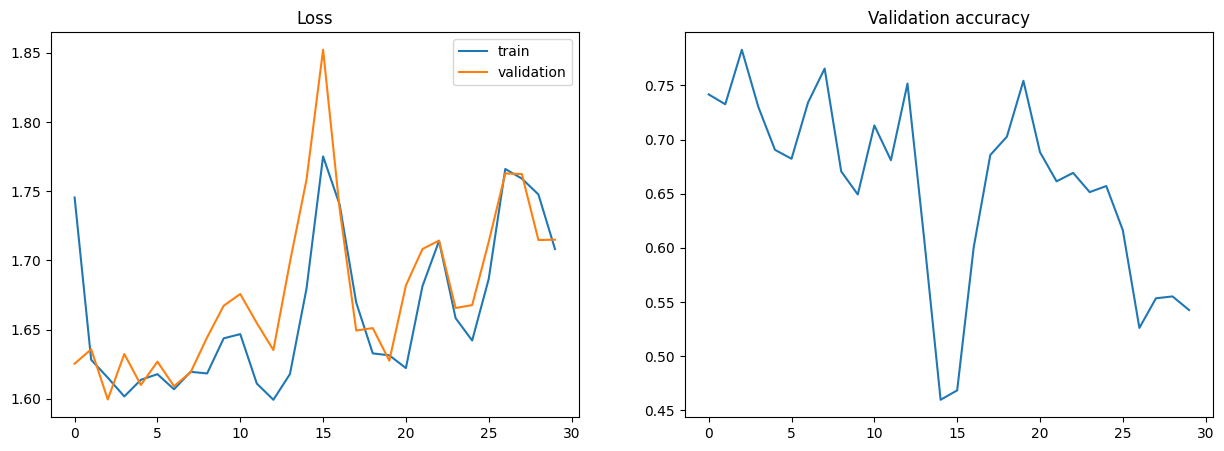

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

## Your turn
Try to add some additional transformations (e.g. random crop, rotation etc.) and train your model!

### Dropout and Batchnorm try

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 600),
    nn.BatchNorm1d(600),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(600, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(500, 400),
    nn.BatchNorm1d(400),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(400, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(200, 10),
    nn.Sigmoid()
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
n_epochs = 30

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 30 took 2.271s
	  training loss: 1.813436
	validation loss: 1.613150
	validation accuracy: 0.883
Epoch 2 of 30 took 1.601s
	  training loss: 1.620979
	validation loss: 1.570360
	validation accuracy: 0.897
Epoch 3 of 30 took 1.661s
	  training loss: 1.598430
	validation loss: 1.560877
	validation accuracy: 0.897
Epoch 4 of 30 took 1.528s
	  training loss: 1.577482
	validation loss: 1.553503
	validation accuracy: 0.911
Epoch 5 of 30 took 1.580s
	  training loss: 1.556941
	validation loss: 1.561034
	validation accuracy: 0.894
Epoch 6 of 30 took 1.552s
	  training loss: 1.554831
	validation loss: 1.558579
	validation accuracy: 0.893
Epoch 7 of 30 took 1.668s
	  training loss: 1.546965
	validation loss: 1.564769
	validation accuracy: 0.890
Epoch 8 of 30 took 2.784s
	  training loss: 1.537434
	validation loss: 1.559489
	validation accuracy: 0.898
Epoch 9 of 30 took 2.467s
	  training loss: 1.530671
	validation loss: 1.563068
	validation accuracy: 0.888
Epoch 10 of 30 took 1.581s
	

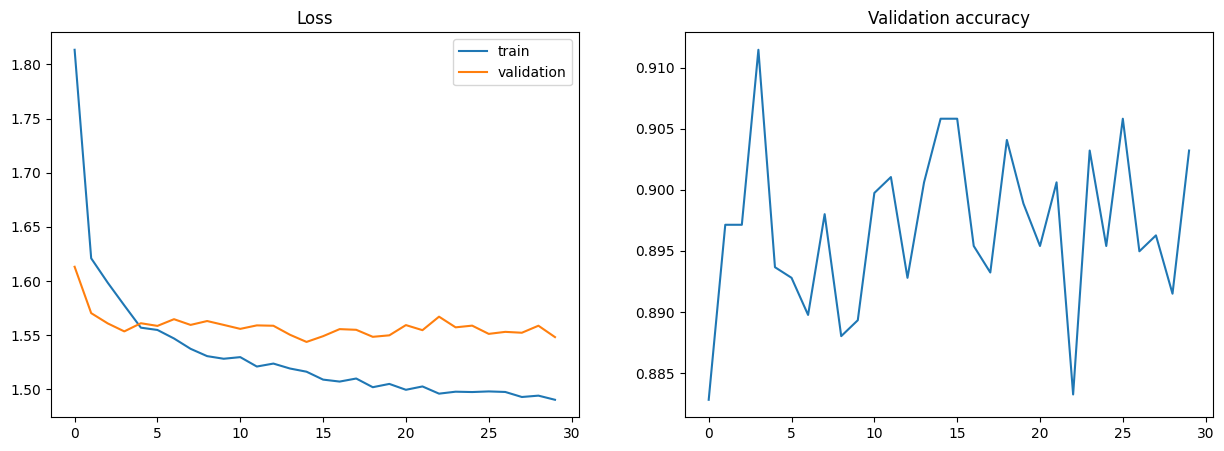

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

### 3. Save the model (model checkpointing)

Now we have trained a model! Obviously we do not want to retrain the model everytime we want to use it. Plus if you are training a super big model, you probably want to save checkpoint periodically so that you can always fall back to the last checkpoint in case something bad happened or you simply want to test models at different training iterations.

Model checkpointing is fairly simple in PyTorch. First, we define a helper function that can save a model to the disk

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer):
    # state_dict: a Python dictionary object that:
    # - for a model, maps each layer to its parameter tensor;
    # - for an optimizer, contains info about the optimizer’s states and hyperparameters used.
    state = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print("model saved to %s" % checkpoint_path)


def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    print("model loaded from %s" % checkpoint_path)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 600)
        self.bn1 = nn.BatchNorm1d(600)
        self.fc2 = nn.Linear(600, 500)
        self.bn2 = nn.BatchNorm1d(500)
        self.fc3 = nn.Linear(500, 400)
        self.bn3 = nn.BatchNorm1d(400)
        self.fc4 = nn.Linear(400, 200)
        self.bn4 = nn.BatchNorm1d(200)
        self.fc5 = nn.Linear(200, 10)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc5(x))
        return x

In [ ]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#### Define a training loop with model checkpointing

In [ ]:
def test(model):
    model.train(False)  # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            preds = model(X_batch)
            test_loss = F.nll_loss(preds, y_batch)

            # compute predictions
            y_pred = preds.max(-1)[1]
            test_accuracy = (y_pred == y_batch).to(default_dtype).mean().item()

    print(f"\ttest loss: {test_loss:.6f}")
    print(f"\ttest accuracy: {test_accuracy:.3f}")

In [ ]:
def train_save(epoch, save_interval, log_interval=100):
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if iteration % log_interval == 0:
                print(
                    "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                        ep,
                        batch_idx * len(data),
                        len(train_loader.dataset),
                        100.0 * batch_idx / len(train_loader),
                        loss.item(),
                    )
                )
            # different from before: saving model checkpoints
            if iteration % save_interval == 0 and iteration > 0:
                save_checkpoint("mnist-%i.pth" % iteration, model, optimizer)
            iteration += 1

    test(model)
    # save the final model
    save_checkpoint("mnist-%i.pth" % iteration, model, optimizer)

In [ ]:
train_save(5, save_interval=500, log_interval=100)

Train Epoch: 0 [0/2996 (0%)]	Loss: -0.507263
Train Epoch: 1 [192/2996 (6%)]	Loss: -0.727891
Train Epoch: 2 [384/2996 (13%)]	Loss: -0.840432
Train Epoch: 3 [576/2996 (19%)]	Loss: -0.882056
Train Epoch: 4 [768/2996 (26%)]	Loss: -0.930556
	test loss: -0.931903
	test accuracy: 0.750
model saved to mnist-470.pth


In [ ]:
# create a new model
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# load from the final checkpoint
load_checkpoint("mnist-470.pth", model, optimizer)
# should give you the final model accuracy
test(model)

model loaded from mnist-470.pth
	test loss: -0.917514
	test accuracy: 0.583


In [ ]:
train_save(5, save_interval=500, log_interval=100)

Train Epoch: 0 [0/2996 (0%)]	Loss: -0.937099
Train Epoch: 1 [192/2996 (6%)]	Loss: -0.941880
Train Epoch: 2 [384/2996 (13%)]	Loss: -0.964270
Train Epoch: 3 [576/2996 (19%)]	Loss: -0.977295
Train Epoch: 4 [768/2996 (26%)]	Loss: -0.968547
	test loss: -0.982373
	test accuracy: 1.000
model saved to mnist-470.pth


### 4. Convolutions and derivatives understanding

Animation in Figure illustrates a convolution for a 3x3 kernel applied to 3 channels of 5x5 inputs with no padding and using unit stride to get 1 output channel.

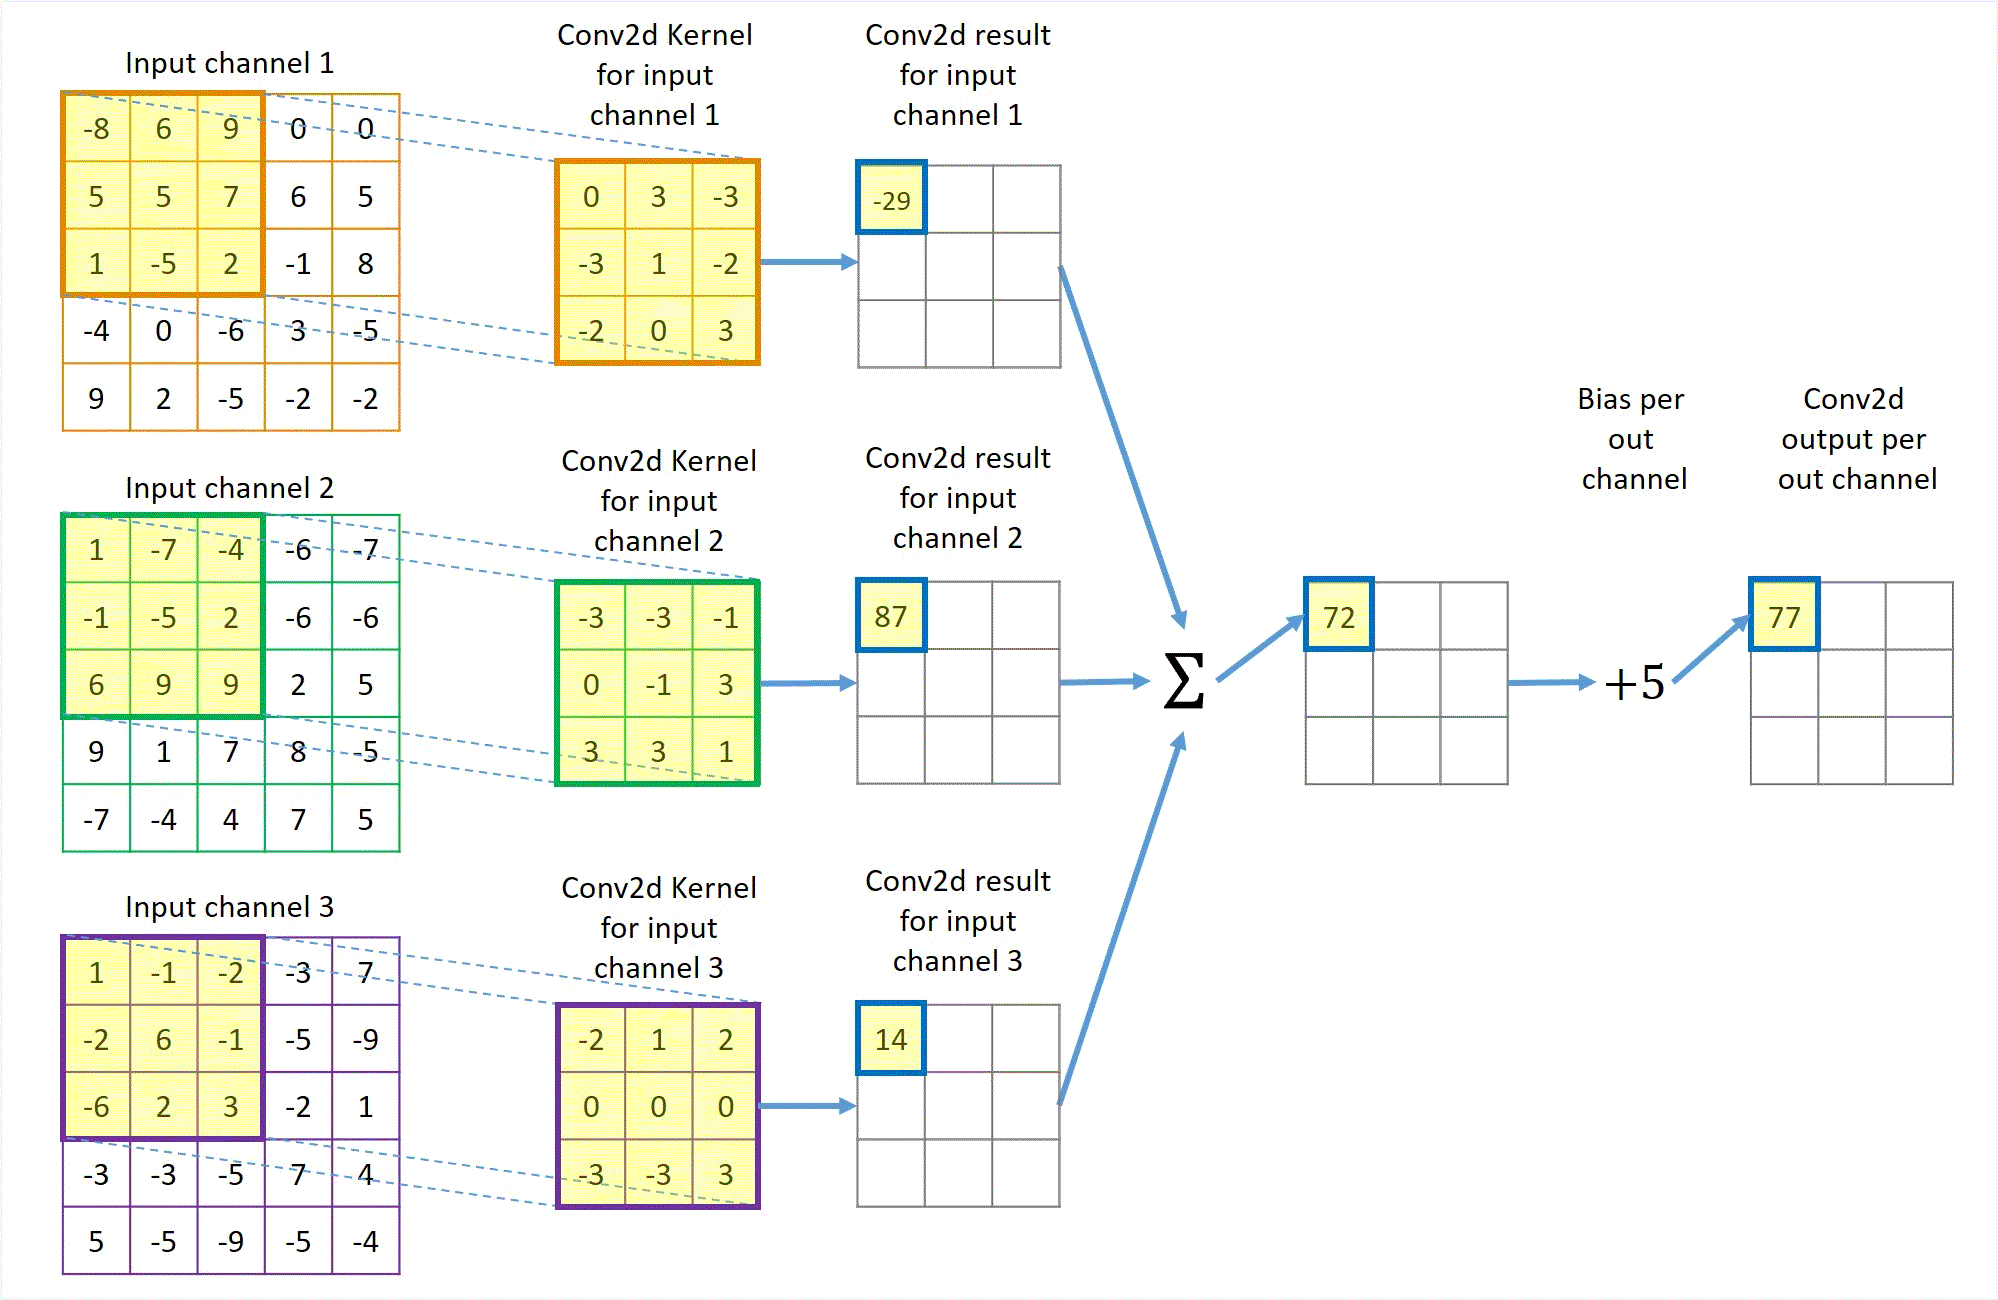

- [Back-propagation in a convolution layer with numpy implementation](https://numbersmithy.com/back-propagation-in-a-convolution-layer-with-numpy-implementation/) <-- math + practice 💪

- [Backpropagation In Convolutional Neural Networks](https://www.jefkine.com/general/2016/09/05/backpropagation-in-convolutional-neural-networks/) <-- best one 💯

- [Derivation of Backpropagation in Convolutional Neural Network (CNN)](https://www.quarkml.com/2023/07/backward-pass-in-convolutional-neural-network-explained.html) <-- with some .gif vizualization 📺

### 5. Model with Convolutions

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout(0.2),

    nn.Flatten(),

    nn.Linear(64*7*7, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(128, 10),
    nn.Sigmoid()
)
model.to(device, torch.float32)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Define transforms for data preprocessing
new_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # output dist [-1, 1]
])

In [ ]:
# Load full dataset and create subset
full_dataset = DatasetMNIST("./notMNIST_small", "AB", transform=new_transform)
shrink_inds = subset_ind(full_dataset, 0.2)
dataset = Subset(full_dataset, shrink_inds)

# Split into train/validation
val_size = 0.2
val_inds = subset_ind(dataset, val_size)
train_dataset = Subset(dataset, [i for i in range(len(dataset)) if i not in val_inds])
val_dataset = Subset(dataset, val_inds)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [ ]:
n_epochs = 10

train_loss, val_loss, val_accuracy = train_model(
    model, train_loader, val_loader, loss_func, opt, n_epochs
)

Epoch 1 of 10 took 1.464s
	  training loss: 1.966554
	validation loss: 1.958742
	validation accuracy: 0.774
Epoch 2 of 10 took 1.631s
	  training loss: 1.705697
	validation loss: 1.684228
	validation accuracy: 0.947
Epoch 3 of 10 took 1.830s
	  training loss: 1.600991
	validation loss: 1.595233
	validation accuracy: 0.956
Epoch 4 of 10 took 1.304s
	  training loss: 1.548604
	validation loss: 1.557263
	validation accuracy: 0.953
Epoch 5 of 10 took 1.309s
	  training loss: 1.524563
	validation loss: 1.536279
	validation accuracy: 0.959
Epoch 6 of 10 took 1.289s
	  training loss: 1.510156
	validation loss: 1.519895
	validation accuracy: 0.969
Epoch 7 of 10 took 1.309s
	  training loss: 1.496462
	validation loss: 1.513057
	validation accuracy: 0.975
Epoch 8 of 10 took 1.295s
	  training loss: 1.491778
	validation loss: 1.509155
	validation accuracy: 0.972
Epoch 9 of 10 took 1.308s
	  training loss: 1.486924
	validation loss: 1.503965
	validation accuracy: 0.972
Epoch 10 of 10 took 1.321s
	

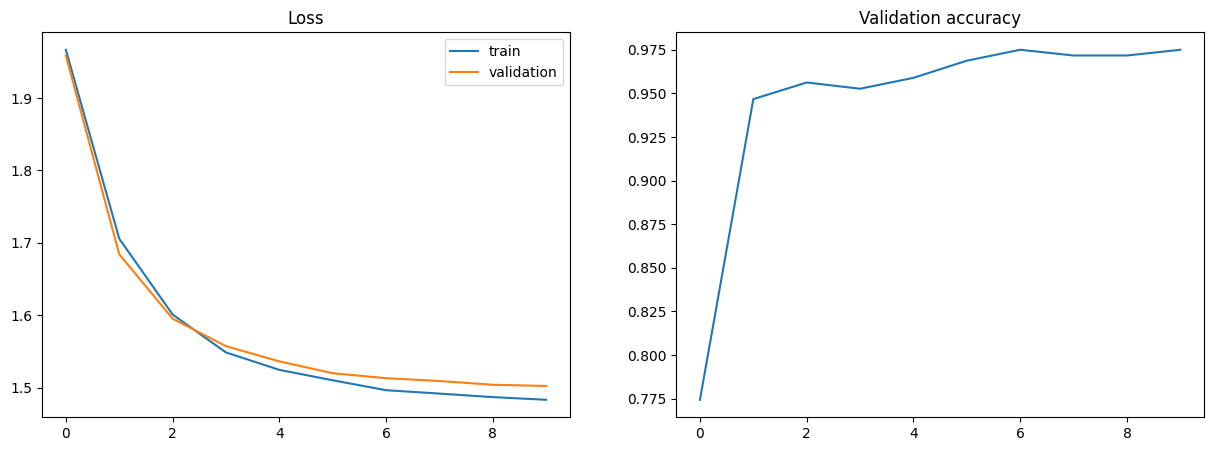

In [ ]:
plot_train_process(train_loss, val_loss, val_accuracy)

```

```

```

```

```

```

```

```

```

```
### More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)